# Import


In [ ]:
!pip install ydata-profiling
!pip install ydata-profiling pandas-downcast phi
!pip install catboost

In [ ]:
!pip install missingno


In [ ]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
from pdcast import downcast
import json

import phik
from phik.report import plot_correlation_matrix
from phik import report

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import set_config
set_config(display='diagram')

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier, plot_importance
from xgboost import XGBClassifier

import dill
import missingno as msno


import itertools
from collections import *

from scipy.stats import entropy

#Описание данных

Данные из Google Analytics (last-click attribution model) по сайту «СберАвтоподписка».

**Файл 1. GA Sessions (ga_sessions.pkl)**

*Одна строка = один визит на сайт.*

Описание атрибутов:

* session_id — ID визита;
* client_id — ID посетителя;
* visit_date — дата визита;
* visit_time — время визита;
* visit_number — порядковый номер визита клиента;
* utm_source — канал привлечения;
* utm_medium — тип привлечения;
* utm_campaign — рекламная кампания;
* utm_keyword — ключевое слово;
* device_category — тип устройства;
* device_os — ОС устройства;
* device_brand — марка устройства;
* device_model — модель устройства;
* device_screen_resolution — разрешение экрана;
* device_browser — браузер;
* geo_country — страна;
* geo_city — город.


**Файл 2. GA Hits (ga_hits.pkl)**

*Одна строка = одно событие в рамках одного визита на сайт.*

Описание атрибутов:

* session_id — ID визита;
* hit_date — дата события;
* hit_time — время события;
* hit_number — порядковый номер события в рамках сессии;
* hit_type — тип события;
* hit_referer — источник события;
* hit_page_path — страница события;
* event_category — тип действия;
* event_action — действие;
* event_lable — тег действия;
* event_value — значение результата действия.

#Подготовка данных


##Загрузка данных

In [ ]:
import os

# Монтируем диск
from google.colab import drive
drive.mount('/content/drive')

# Указываем путь до нужной папки
path = '/content/drive/MyDrive/Юля/' #здесь укажите папку проекта, где лежат данные (если работаете в Колабе)

# Создадим папку, если её нет
os.makedirs(path, exist_ok=True)

# Проверим, что путь установлен
print("Абсолютный путь до данных:", path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Абсолютный путь до данных: /content/drive/MyDrive/Юля/


In [ ]:
path_ga_hits = '/content/drive/MyDrive/Юля/ga_hits.csv'
path_ga_sessions = '/content/drive/MyDrive/Юля/ga_sessions.csv'

import json #создаем один общий json для удобства работы

url_dict = {
    "ga_hits_csv": path_ga_hits,
    "ga_sessions_csv": path_ga_sessions
}

# Сохраняем на Google Диске
json_path = '/content/drive/MyDrive/Юля/URL_for_load.json'

with open(json_path, 'w', encoding='utf-8') as f:
    json.dump(url_dict, f, indent=4)

#Первичный анализ датасетов и объединение данных

Проведем первичный анализ имееющихся датасетов **ga_sessions** и **ga_hits**. В датасете ga_hits содержатся данные о событиях из датасета ga_sessions.

Целевые действия находятся в датасете **ga_hits** столбце **event_action **



*   Уникальных событий - 230
*   Топ событий: **view_card, view_new_card, sub_landing, go_to_car_card, sub_view_cars_click**
*  Максимальное число событий за одну сессию - 768
*   Среднее число событий за сессию 1-50

Несмотря на топ событий, мы не можем отнести их к ЦД, так как они не ведут к конверсии.

Следуя бизнес логике наиболее значимыми событиями являются:

* **sub_car_claim_click** Клик на форму заявки — признак интереса к покупке
* **sub_open_dialog_click** Открытие чата — готовность к диалогу с продавцом
* **sub_submit_success** Завершение формы — высокая вовлечённость
* **sub_car_claim_submit_click** Отправка заявки — прямой лид
* **sub_call_number_click**	Попытка позвонить — прямой лид
* **sub_callback_submit_click** Запрос на звонок — высокая конверсия
* **sub_car_request_submit_click**  Запрос автомобиля — высокая конверсия
* **sub_custom_question_submit_click** Отправка вопроса — высокая вовлечённость

Распределение событий:


* sub_car_claim_click                 =    37928  |   0.24 %
* sub_open_dialog_click               =    25870  |   0.16 %
* sub_submit_success                  =    18439  |   0.12 %
* sub_car_claim_submit_click          =    12359  |   0.08 %
* sub_call_number_click               =     3653  |   0.02 %
* sub_callback_submit_click           =     3074  |   0.02 %
* sub_car_request_submit_click        =     2966  |   0.02 %
* sub_custom_question_submit_click    =      619  |   0.00 %



In [ ]:
df_ga_sessions = pd.read_csv(
    url_dict['ga_sessions_csv'],
    dtype={
        'session_id': 'category',
        'client_id': 'category'
    }
)

df_ga_sessions.sample(10)

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city
498213,2982045857374164149.1622633744.1622633744,694311656.1622561973,2021-06-02,14:00:00,4,aXQzDWsJuGXeBXexNHjc,referral,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Apple,NaN,414x896,Safari,Russia,Saint Petersburg
1174451,5999964972202881741.1626370767.1626370767,1396975706.1626370765,2021-07-15,20:00:00,1,BHcvLfOaCWvWTykYqHVe,cpc,NaN,NaN,NaN,desktop,NaN,NaN,NaN,2560x1080,Chrome,Russia,(not set)
898626,4770355937468021015.1626667290.1626667290,1110685043.1626667287,2021-07-19,07:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Huawei,NaN,360x780,Android Webview,Russia,Ryazan
268241,1957826951922106197.1627438934.1627439586,455842109.1627438933,2021-07-28,05:00:00,1,bByPQxmDaMXgpHeypKSM,referral,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Leagoo,NaN,360x640,Chrome,Russia,Barnaul
64141,1039329650002786127.1626502994.1626502994,241987791.1626502991,2021-07-17,09:00:00,1,gDBGzjFKYabGgSPZvrDH,cpm,FTjNLDyTrXaWYgZymFkV,UxrnyMlRBSOhOjytXnMG,NaN,desktop,NaN,NaN,NaN,1600x900,Chrome,Russia,Saint Petersburg
707668,3918967529613653593.1625928099.1625928099,912455732.1625912921,2021-07-10,17:00:00,2,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Apple,NaN,390x844,Safari,Russia,Saint Petersburg
392313,2511062166061093024.1627295908.1627295908,584652220.1627295904,2021-07-26,13:00:00,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,dUuXlWzvmhDSyclWRhNP,NaN,mobile,NaN,Samsung,NaN,412x892,YaBrowser,Russia,Moscow
1196671,6099134349735910826.1633967530.1633967530,1420065376.1633967530,2021-10-11,18:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Apple,NaN,390x844,Chrome,Russia,Saint Petersburg
464141,2828615563842860771.1627305699.1627305748,658588382.1627305699,2021-07-26,16:00:00,1,bByPQxmDaMXgpHeypKSM,referral,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Apple,NaN,375x812,Safari,Russia,Moscow
162343,1480333760930340248.1631940483.1631940483,344667062.1631935896,2021-09-18,07:00:00,2,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,PkybGvWbaqORmxjNunqZ,NaN,mobile,NaN,Xiaomi,NaN,360x640,Chrome,Russia,Moscow


In [ ]:
df_ga_hits = pd.read_csv(
    url_dict['ga_hits_csv'],
    dtype={
        'session_id': 'category',
        'client_id': 'category'
    }
)

df_ga_hits.sample(10)


,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value
6090300,905761892286946122.1624857418.1624857418,2021-06-28,NaN,10,event,HbolMJUevblAbkHClEQa,sberauto.com/cars/bf24b977?rental_page=rental_car,card_web,view_new_card,KclpemfoHstknWHFiLit,NaN
9781474,2316475988367387043.1633429925.1633429925,2021-10-05,NaN,17,event,HbolMJUevblAbkHClEQa,sberauto.com/cars/all/audi/e-tron/642fe08f?ren...,card_web,view_card,KclpemfoHstknWHFiLit,NaN
4577375,4228145298784164203.1623497077.1623497077,2021-06-12,NaN,29,event,HbolMJUevblAbkHClEQa,sberauto.com/cars?brand=179&city=1&city=18&ren...,search_form,search_form_search_btn,MbQsNZxBQkusqOKQZfWz,NaN
483256,3291259124469815972.1640585891.1640585891,2021-12-27,5179.0,4,event,NaN,podpiska.sberauto.com/,sub_page_view,sub_landing,NaN,NaN
11413980,6422130089557667677.1634643804.1634643880,2021-10-19,NaN,29,event,HbolMJUevblAbkHClEQa,sberauto.com/cars/all/mercedes-benz/gla-klasse...,card_web,view_new_card,KclpemfoHstknWHFiLit,NaN
4820872,8063532269272076311.1625067544.1625067544,2021-06-30,NaN,24,event,HbolMJUevblAbkHClEQa,sberauto.com/cars?city=1&city=18&rental_car=re...,search_form,search_form_model_select,bPlWjEmRrsjsSfgEgNte,NaN
15487549,9052079710410291594.1636219274.1636219274,2021-11-06,128695.0,13,event,NaN,sberauto.com/cars/all/skoda/karoq/94b3d18e?utm...,card_web,view_new_card,NaN,NaN
14129792,5873370798278644533.1636887146.1636887146,2021-11-14,2500824.0,160,event,NaN,sberauto.com/cars?city=1&city=18&isnew=false&r...,search_form,search_power_from,yatapsJsSVhXEatMiuad,NaN
12332103,395692070142681630.1632313885.1632313885,2021-09-22,329.0,3,event,NaN,sberauto.com/cars/bfc21661?rental_page=rental_car,card_web,view_card,NaN,NaN
6181879,3055615009316721618.1621939156.1621939156,2021-05-25,NaN,88,event,HbolMJUevblAbkHClEQa,sberauto.com/cars/e1f862ea?rental_page=rental_car,card_web,photos,KclpemfoHstknWHFiLit,NaN


In [ ]:
# выведем значения и их количество из столбца event_action
df_ga_hits.event_action.value_counts().head(10)

,count
event_action,
view_card,3558985
view_new_card,3551009
sub_landing,1798117
go_to_car_card,973666
sub_view_cars_click,791515
search_form_region,512069
search_form_search_btn,433748
sap_search_form_cost_to,356596
showed_number_ads,326274


In [ ]:
# Выведем сколько всего уникальных значений в event_action
df_ga_hits.event_action.nunique()

230


Статистика по целевым действиям:

sub_car_claim_click                 =    37928  |   0.24 %
sub_open_dialog_click               =    25870  |   0.16 %
sub_submit_success                  =    18439  |   0.12 %
sub_car_claim_submit_click          =    12359  |   0.08 %
sub_call_number_click               =     3653  |   0.02 %
sub_callback_submit_click           =     3074  |   0.02 %
sub_car_request_submit_click        =     2966  |   0.02 %
sub_custom_question_submit_click    =      619  |   0.00 %

Всего целевых действий: 104908 из 15726470 (0.67 % от всех событий)



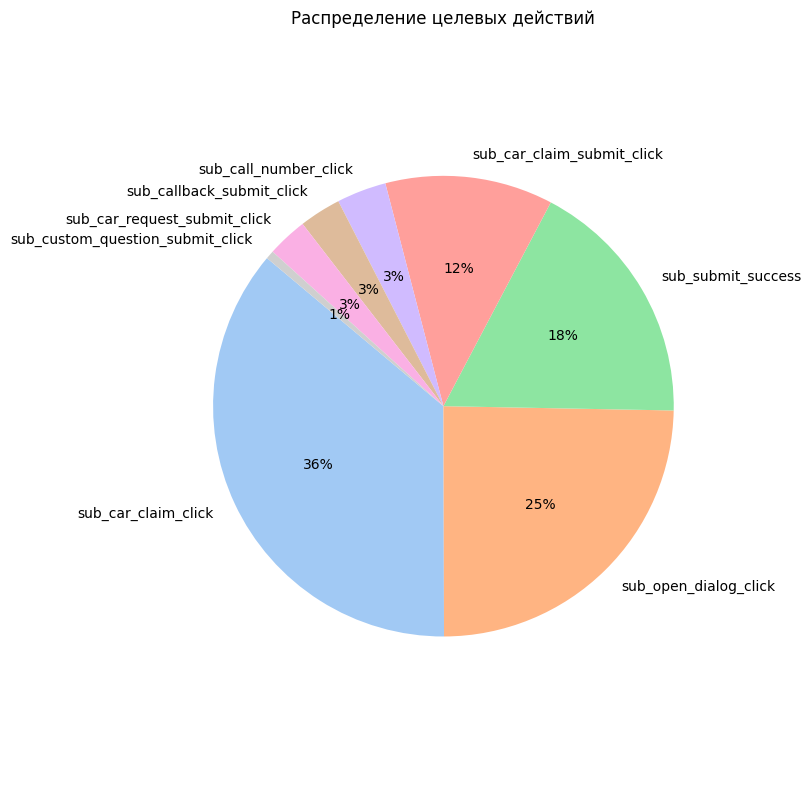

In [ ]:


# Список целевых действий
all_targets = [
    'sub_car_claim_click',
    'sub_car_claim_submit_click',
    'sub_open_dialog_click',
    'sub_custom_question_submit_click',
    'sub_call_number_click',
    'sub_callback_submit_click',
    'sub_submit_success',
    'sub_car_request_submit_click'
]

# Подсчёт количества и доли каждого действия
total_events = len(df_ga_hits)
target_stats = []

for target in all_targets:
    count = (df_ga_hits['event_action'] == target).sum()
    percent = round(count / total_events * 100, 2)
    target_stats.append((target, count, percent))

# Сортировка по количеству
target_stats = sorted(target_stats, key=lambda x: x[1], reverse=True)

# Вывод информации
print("\nСтатистика по целевым действиям:\n")
for name, count, percent in target_stats:
    print(f"{name:<35} = {count:>8}  |  {percent:>5.2f} %")

total_target_count = sum(t[1] for t in target_stats)
total_percent = round(total_target_count / total_events * 100, 2)
print(f"\nВсего целевых действий: {total_target_count} из {total_events} "
      f"({total_percent:.2f} % от всех событий)\n")

# Подготовка данных для диаграммы
labels = [f"{name}" for name, _, _ in target_stats]
sizes = [count for _, count, _ in target_stats]
colors = sns.color_palette('pastel')[:len(labels)]

# Построение круговой диаграммы
plt.figure(figsize=(8, 8))
plt.title("Распределение целевых действий")
plt.pie(sizes, labels=labels, colors=colors, autopct='%.0f%%', startangle=140)
plt.axis('equal')  # делает круг
plt.tight_layout()
plt.show()


In [ ]:
event_counts = df_ga_hits['session_id'].value_counts() # выведем количество событий в одну сессию
event_counts.head(5)

,count
session_id,
5442565791571325612.1632449195.1632449195,768
6568868914238486437.1632270313.1632270313,678
5959671972744778783.1632490527.1632490600,548
7452598043578978502.1632358598.1632358598,514
3070792010704358528.1629752408.1629752408,498


In [ ]:
# Сколько сессий содержат несколько событий
freq_table = event_counts.value_counts().sort_index().reset_index(name='n_sessions')
freq_table.columns = ['n_events_in_session', 'n_sessions']
freq_table



,n_events_in_session,n_sessions
0,1,537243
1,2,237658
2,3,85233
3,4,63603
4,5,37803
...,...,...
346,498,1
347,514,1
348,548,1
349,678,1


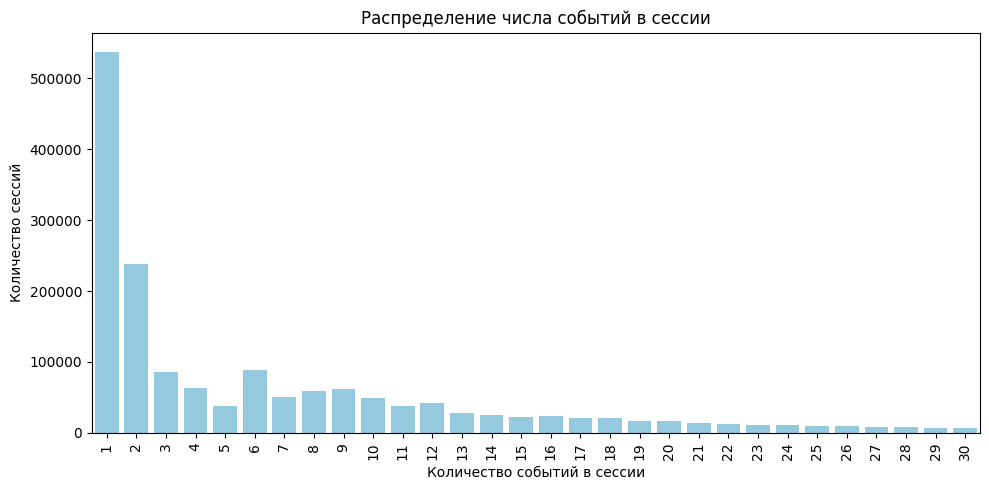

In [ ]:
plt.figure(figsize=(10, 5)) #Построим диаграмму распределения числа событий на сессию
sns.barplot(data=freq_table.head(30), x='n_events_in_session', y='n_sessions', color='skyblue')
plt.title('Распределение числа событий в сессии')
plt.xlabel('Количество событий в сессии')
plt.ylabel('Количество сессий')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

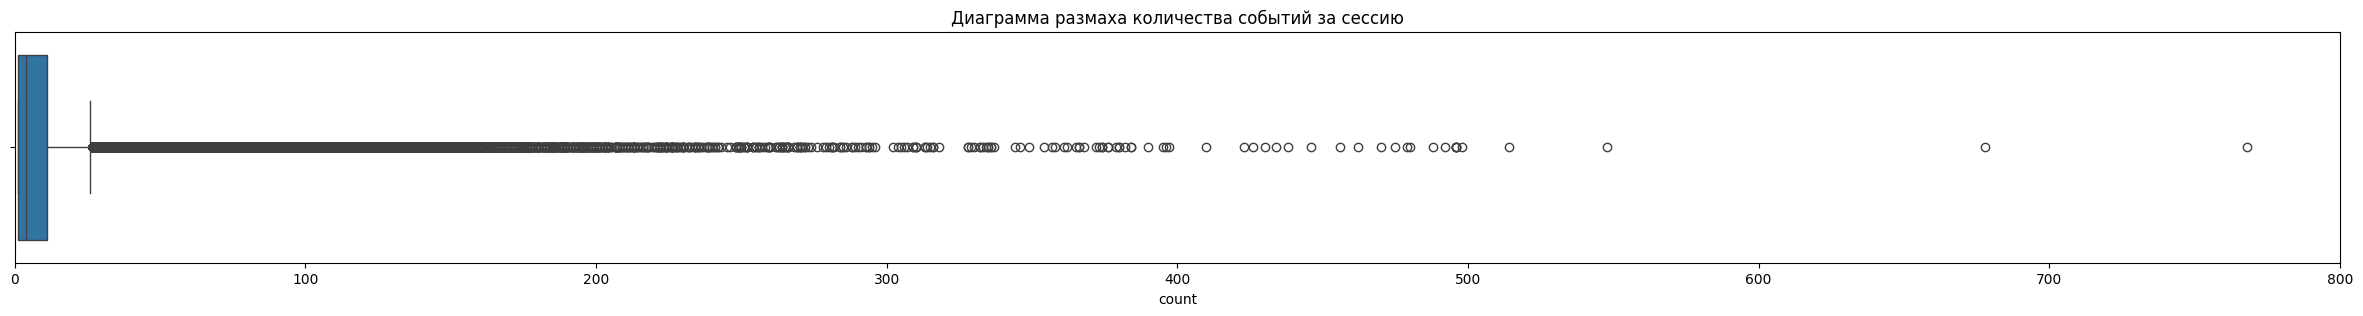

In [ ]:
plt.figure(figsize=(30, 3)) #Построим еще boxplot для наглядности
plt.title('Диаграмма размаха количества событий за сессию')
plt.xlim(0, 800)
sns.boxplot(x=event_counts);


В датасете **df_session**  хранятся данные о сессии пользователей.

Из файла **ga_hits** забираем данные, которые касаются целевых действий. Поэтому получаем из него столбцы **session_id** и **event_action**. С их помощью будем выводить целевую переменную **target**

In [ ]:
df_ga_hits = pd.read_csv(url_dict['ga_hits_csv'],
                         usecols=['session_id', 'event_action'],
                         dtype={
                             'session_id': 'category',
                             'event_action': 'category'
                         })
df_ga_hits.sample()


,session_id,event_action
7462970,2751686836939058175.1625386934.1625386934,jivo_viber


Зададим список целевых действий из файла **ga_hits**

In [ ]:
event_action_list = [
    'sub_car_claim_click', 'sub_car_claim_submit_click',
    'sub_open_dialog_click', 'sub_custom_question_submit_click',
    'sub_call_number_click', 'sub_callback_submit_click',
    'sub_submit_success', 'sub_car_request_submit_click'
]

Обозначим действия как целевые/нецелевые

In [ ]:
df_ga_hits['target'] = df_ga_hits.event_action\
    .isin(event_action_list)\
        .map({True: 1, False: 0})
df_ga_hits.sample(10)

,session_id,event_action,target
13471092,5543194912513458867.1634384329.1634384329,view_new_card,0
4529375,5892616233186227113.1623454636.1623454636,sub_view_cars_click,0
7498851,5701992510714905327.1629061871.1629061894,view_card,0
1092531,2165850884004175846.1636360166.1636360166,view_new_card,0
9778361,5357188473154772929.1635175830.1635175830,showed_number_ads,0
1935391,1281073284429356664.1638390133.1638390133,view_card,0
8609153,5292843652537198118.1630086696.1630086696,sub_car_claim_submit_click,1
13977537,3918799184082608905.1633018092.1633018092,view_card,0
8239514,3194752630951690392.1629405338.1629405338,view_card,0
9568831,2365602459949658098.1628893171.1628893209,sub_landing,0


Сгруппируем действия пользователей по столбцу session_id и пометим, есть  целевое действие или нет.

In [ ]:
df_target = df_ga_hits.groupby(['session_id'], as_index=False).agg(
    target=pd.NamedAgg(
        column='target',
        aggfunc='max'
    ),
)
df_target.shape

/tmp/ipython-input-47-2632137975.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_target = df_ga_hits.groupby(['session_id'], as_index=False).agg(


(1734610, 2)

Объединим оба файла, установим session_id в качестве индекса и сохраним в наш json **ga_mixed.csv**

In [ ]:
df_inner = pd.merge(left=df_ga_sessions,
                    right=df_target,
                    on='session_id',
                    how='inner').set_index('session_id')

df_inner.to_csv('/content/drive/MyDrive/Юля/ga_mixed.csv.zip')
df_inner.sample(5)


,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city,target
session_id,,,,,,,,,,,,,,,,,,
7283730065630715106.1639996645.1639996645,1695875559.1639996642,2021-12-20,13:37:25,1,ZpYIoDJMcFzVoPFsHGJL,banner,zxoiLxhuSIFrCeTLQVWZ,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Samsung,NaN,320x569,Chrome,Russia,Chita,0
115914593346600083.1622792246.1622792246,26988469.1622490259,2021-06-04,10:00:00,6,kjsLglQLzykiRbcDiGcD,cpc,NCOBaqbWTRpdTXezdNNg,XKsYZiUFcdkUXQpoLKyS,NaN,mobile,NaN,Samsung,NaN,360x800,Chrome,Russia,Vladivostok,0
383346208133744470.1640892247.1640892247,89254744.1640892246,2021-12-30,22:24:07,1,eLzNJHzPelJpEyBwMrKo,cpm,FTjNLDyTrXaWYgZymFkV,AdeErYgVTbRcAWtHrMHq,pucKZkLDtpMDBTobJAJG,mobile,Android,Meizu,ciZAODXEPQGDKvuEabGr,360x720,Android Webview,Russia,Balashikha,0
6733433893310938906.1633664795.1633664795,1567749747.1633664794,2021-10-08,06:00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,gecBYcKZCPMcVYdSSzKP,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Huawei,NaN,320x685,Chrome,Russia,Rostov-on-Don,1
3970965904100183116.1628747469.1628747469,924562547.1628720204,2021-08-12,08:00:00,3,kjsLglQLzykiRbcDiGcD,organic,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Apple,NaN,375x812,Safari,Russia,Novorossiysk,0


#Анализируем объединенный датасет

Теперь все данные содержатся в одном датасете. Откроем ga_mixed.csv. Столбец session_id содержит только уникальные значения.

In [ ]:
df_load = pd.read_csv(
    '/content/drive/MyDrive/Юля/ga_mixed.csv.zip',
    compression='zip',
    encoding='utf-8',
    index_col='session_id'
)
df = df_load.copy()
df.sample(10)

,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city,target
session_id,,,,,,,,,,,,,,,,,,
8940550602412304357.1630582195.1630582195,2.081634e+09,2021-09-02,14:00:00,2,ZpYIoDJMcFzVoPFsHGJL,banner,gecBYcKZCPMcVYdSSzKP,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Huawei,NaN,360x640,Chrome,Russia,Yekaterinburg,0
6812481477892410422.1626715650.1626715650,1.586154e+09,2021-07-19,20:00:00,5,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Xiaomi,NaN,393x873,Chrome,Russia,Yekaterinburg,1
6969371440614564897.1637180542.1637180808,1.622683e+09,2021-11-17,23:26:48,2,bByPQxmDaMXgpHeypKSM,referral,QdLfySaGXolfTBSNVfHn,SOkCdPxfUcZUzzOdgGES,puhZPIYqKXeFPaUviSjo,mobile,iOS,Apple,NaN,414x896,Safari,Russia,Moscow,0
8237101917859026611.1621956310.1621956310,1.917850e+09,2021-05-25,18:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Huawei,NaN,360x770,Chrome,Russia,Moscow,0
7292395123491392574.1635699775.1635699775,1.697893e+09,2021-10-31,20:02:55,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,RkpOyeEPgcMBSDuHLQcj,mobile,Android,Huawei,NaN,360x720,YaBrowser,Russia,Saint Petersburg,0
3034343359161167427.1633546196.1633546196,7.064881e+08,2021-10-06,21:00:00,2,kjsLglQLzykiRbcDiGcD,organic,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,(not set),NaN,432x960,Chrome,Russia,Samara,0
2911837238176231618.1631563974.1631563974,6.779649e+08,2021-09-13,23:00:00,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,dUuXlWzvmhDSyclWRhNP,NaN,mobile,NaN,Samsung,NaN,869x412,Chrome,Russia,Moscow,0
6950928443027136279.1640668956.1640668956,1.618389e+09,2021-12-28,08:22:36,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Samsung,NaN,412x943,Chrome,Russia,Moscow,0
3985517695675341942.1624970602.1624970766,9.279507e+08,2021-06-29,15:00:00,16,bByPQxmDaMXgpHeypKSM,referral,vHbfNwUgmVpYgEczIXDW,JNHcPlZPxEMWDnRiyoBf,NaN,desktop,NaN,NaN,NaN,1920x1080,Chrome,Russia,Moscow,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1732266 entries, 9055434745589932991.1637753792.1637753792 to 9055430416266113553.1640968742.1640968742
Data columns (total 18 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   client_id                 float64
 1   visit_date                object 
 2   visit_time                object 
 3   visit_number              int64  
 4   utm_source                object 
 5   utm_medium                object 
 6   utm_campaign              object 
 7   utm_adcontent             object 
 8   utm_keyword               object 
 9   device_category           object 
 10  device_os                 object 
 11  device_brand              object 
 12  device_model              object 
 13  device_screen_resolution  object 
 14  device_browser            object 
 15  geo_country               object 
 16  geo_city                  object 
 17  target                    int64  
dtypes: float64(1), int64(2), object(1

Датасет содержит 18 столбцов:


*   Целевая переменная target (1/0)
*   Числовые данные в столбцах client_id, visit_number
*   visit_date, visit_time - object, но содержат данные даты и времени
*.  Остальные данные имеют категорию object




Просмотрим общую статистику по датасету с помощью инструмента для Data Science(ProfileReport):
1. **Размер и структура датасета**
Объём: 1 732 266 сессий

2. **Признаков**: 19

Пропущенные значения:14.0%

Дубликатов: нет

Объём в памяти: 1.7 ГБ

3. **Целевая активность**
Только 2.9% пользователей совершают целевое действие (например, отправляют заявку, открывают диалог и т.д.).
4. Абсолютное большинство посетителей — из** России** (geo_country = Russia).
5. Наиболее активные города:

**Москва**

**Санкт-Петербург**

Также в выборке представлены города-миллионники и крупные региональные центры.

6. **Устройства**
* Категория устройства (device_category)
* Мобильные — 79% (доминирующий тип устройства)

* Десктопы — около 20%

* Планшеты — менее 1%

* Операционная система (device_os)
* Лидеры: Android и iOS

* Большая часть сессий с iPhone/Apple — особенно в целевых действиях

* Разрешение экрана (device_screen_resolution)
* Самое частое: 414x896 (типично для iPhone X/11/12)

6. **Временные характеристики**
Время суток (visit_time_hour)

* Пик посещений приходится на дневное время (12:00–18:00)
* Минимум активности — ночью

7. **Каналы привлечения**

utm-метки (источники трафика)

Типичная сессия приходит:

С источника: реZpYIoDJMcFzVoPFsHGJL

По метке utm_medium = banner

Кампания: LTuZkdKfxRGVceoWkVyg

Объявление (adcontent): JNHcPlZPxEMWDnRiyoBf

Ключевое слово: puhZPIYqKXeFPaUviSjo

8. **Высокая доля пропусков:**

utm_keyword (58.9%)

device_os (58.5%)

utm_adcontent (17.6%)

device_brand (20.0%)

utm_campaign (11.3%)


In [ ]:
import pandas as pd
from ydata_profiling import ProfileReport

# Загружаем датафрейм из CSV
df = pd.read_csv('/content/drive/MyDrive/Юля/ga_mixed.csv.zip')

# Создаём отчёт
report = ProfileReport(df, title='Отчёт по объединённым сессиям', explorative=True)

# Отображаем в ноутбуке
report.to_notebook_iframe()

Выходные данные этой ячейки слишком велики. Войдите, чтобы просмотреть их.


In [ ]:
df.describe()

,client_id,visit_number,target
count,1.732266e+06,1.732266e+06,1.732266e+06
mean,1.074577e+09,2.627835e+00,2.904519e-02
std,6.201370e+08,1.164260e+01,1.679333e-01
min,2.321640e+02,1.000000e+00,0.000000e+00
25%,5.378943e+08,1.000000e+00,0.000000e+00
50%,1.074614e+09,1.000000e+00,0.000000e+00
75%,1.612130e+09,1.000000e+00,0.000000e+00
max,2.147483e+09,5.640000e+02,1.000000e+00



*  **1 732 266** - уникальных клиентов
* **~2.63** визита в среднем на клиента


*   у **75%** клиентов всего 1 визит
*   **~0.029** — 2.9% сессий были целевыми


*   **0.168** — сильно смещённый бинарный признак (будет влиять на модель, нужно использовать специальные подходы)







#Анализ по дате визита

In [ ]:
min(df.visit_date), max(df.visit_date) #Посмотрим за какой период представлены данные

('2021-05-19', '2021-12-31')

Интервал Данных -  с 19 мая по 31 декабря 2021 года

In [ ]:
n_unique = df_inner['visit_date'].nunique()
print(f'Количество уникальных значений в `visit_date`: {n_unique}')

Количество уникальных значений в `visit_date`: 226


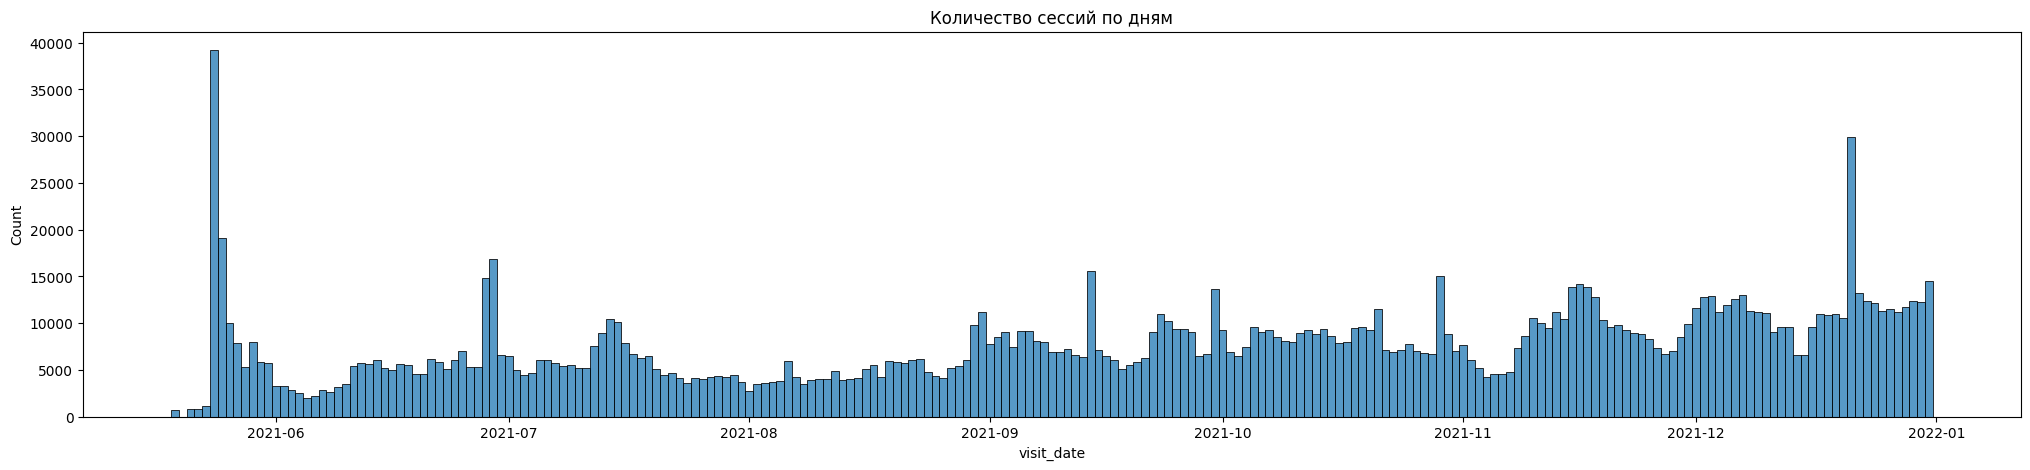

In [ ]:
plt.figure(figsize=(25, 5))
sns.histplot(df_inner, x='visit_date', discrete=True)
plt.title('Количество сессий по дням');

In [ ]:
df.duplicated().sum() #Проверим датасет на наличие дубликатов

np.int64(0)

In [ ]:
df_inner['visit_date'] = pd.to_datetime(df_inner['visit_date']) # переведем данные столбца в формат даты

Чтобы проанализировать количество посещений по дням создадим новые признаки из имеющихся данных с помощью столбца visit_date:

- День недели (visit_date_weekday)
- День месяца (visit_date_day)
- Праздники (visit_date_holiday)
- Час посещения сайта (visit_time_hour)


In [ ]:
df_inner['visit_date_weekday'] = df_inner['visit_date'].dt.day_of_week #анализ посещений по дням

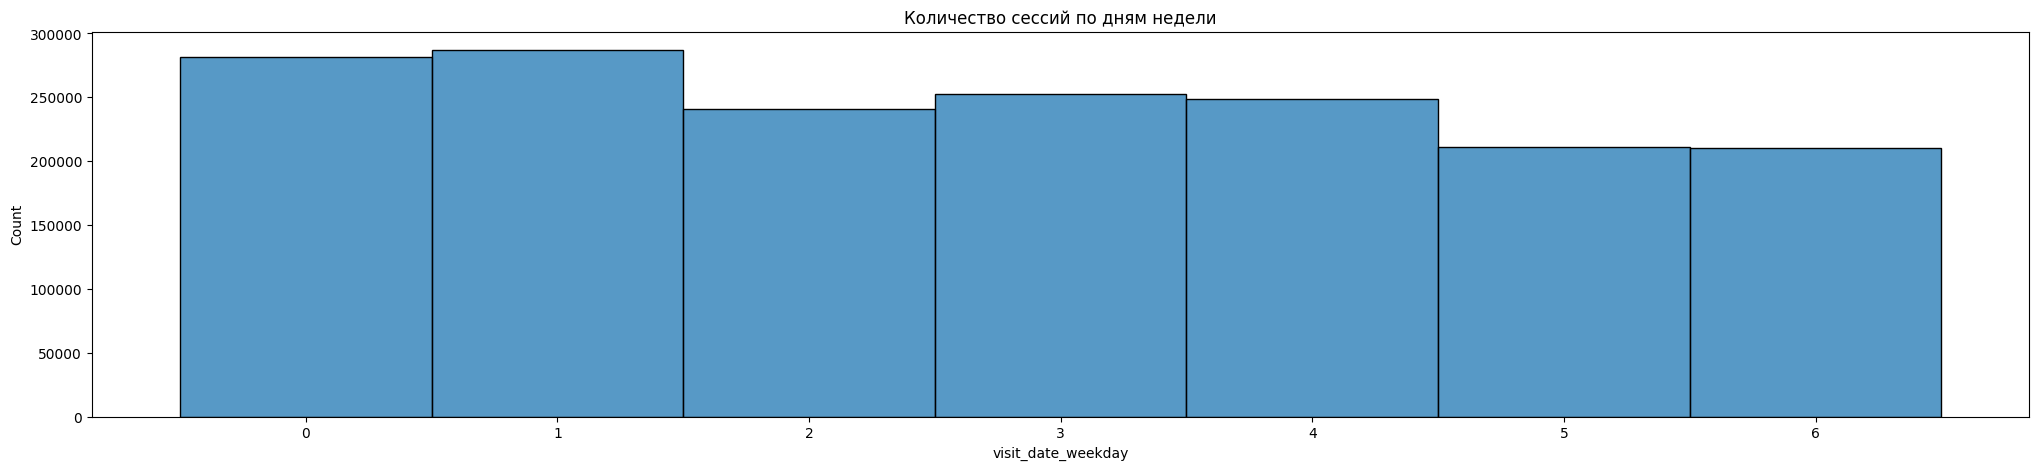

In [ ]:
plt.figure(figsize=(25, 5))
sns.histplot(data=df_inner, x='visit_date_weekday', discrete=True)
plt.title('Количество сессий по дням недели');

In [ ]:
def target_percentage(
    df: pd.DataFrame,
    group_col: str,
    index_name: str = None,
    only_target: bool = False,
    sort: bool = True,
    percent: bool = True
) -> pd.DataFrame:
    """
    Вычисляет статистику по доле целевых действий (target == 1)
    для каждого уникального значения в указанной колонке.

    Параметры:
    - df: DataFrame с колонкой 'target'
    - group_col: колонка для группировки
    - index_name: имя для индекса (по умолчанию = group_col)
    - only_target: вернуть только колонку с процентом целевых действий
    - sort: отсортировать результат по убыванию процента
    - percent: отформатировать как проценты (в строковом виде)

    Возвращает:
    - DataFrame со статистикой или Series, если only_target=True
    """

    grouped = df.groupby(group_col)

    result = pd.DataFrame()
    result['count'] = grouped.size()
    result['Целевое действие'] = grouped['target'].sum() / result['count']
    result['Доля от общего числа'] = result['count'] / len(df)

    if sort:
        result = result.sort_values('Целевое действие', ascending=False)

    if percent:
        result['Целевое действие'] = (result['Целевое действие'] * 100).round(2).astype(str) + '%'
        result['Доля от общего числа'] = (result['Доля от общего числа'] * 100).round(2).astype(str) + '%'

    result.index.name = index_name or group_col

    if only_target:
        return result['Целевое действие'].rename('target_percentage')

    return result


In [ ]:
print('Процент целевых действий по дням недели:')
target_percentage(df_inner, 'visit_date_weekday', index_name='День недели')

Процент целевых действий по дням недели:


,count,Целевое действие,Доля от общего числа
День недели,,,
0,281777,3.36%,16.27%
1,286998,3.02%,16.57%
2,240941,3.02%,13.91%
3,252240,2.87%,14.56%
5,211159,2.64%,12.19%
4,248550,2.64%,14.35%
6,210601,2.63%,12.16%


Для того, чтобы проанализировать посещения по дням в месяце создадим новый признак - день месяца **visit_date_day**

In [ ]:
df_inner['visit_date_day'] = df_inner['visit_date'].dt.day

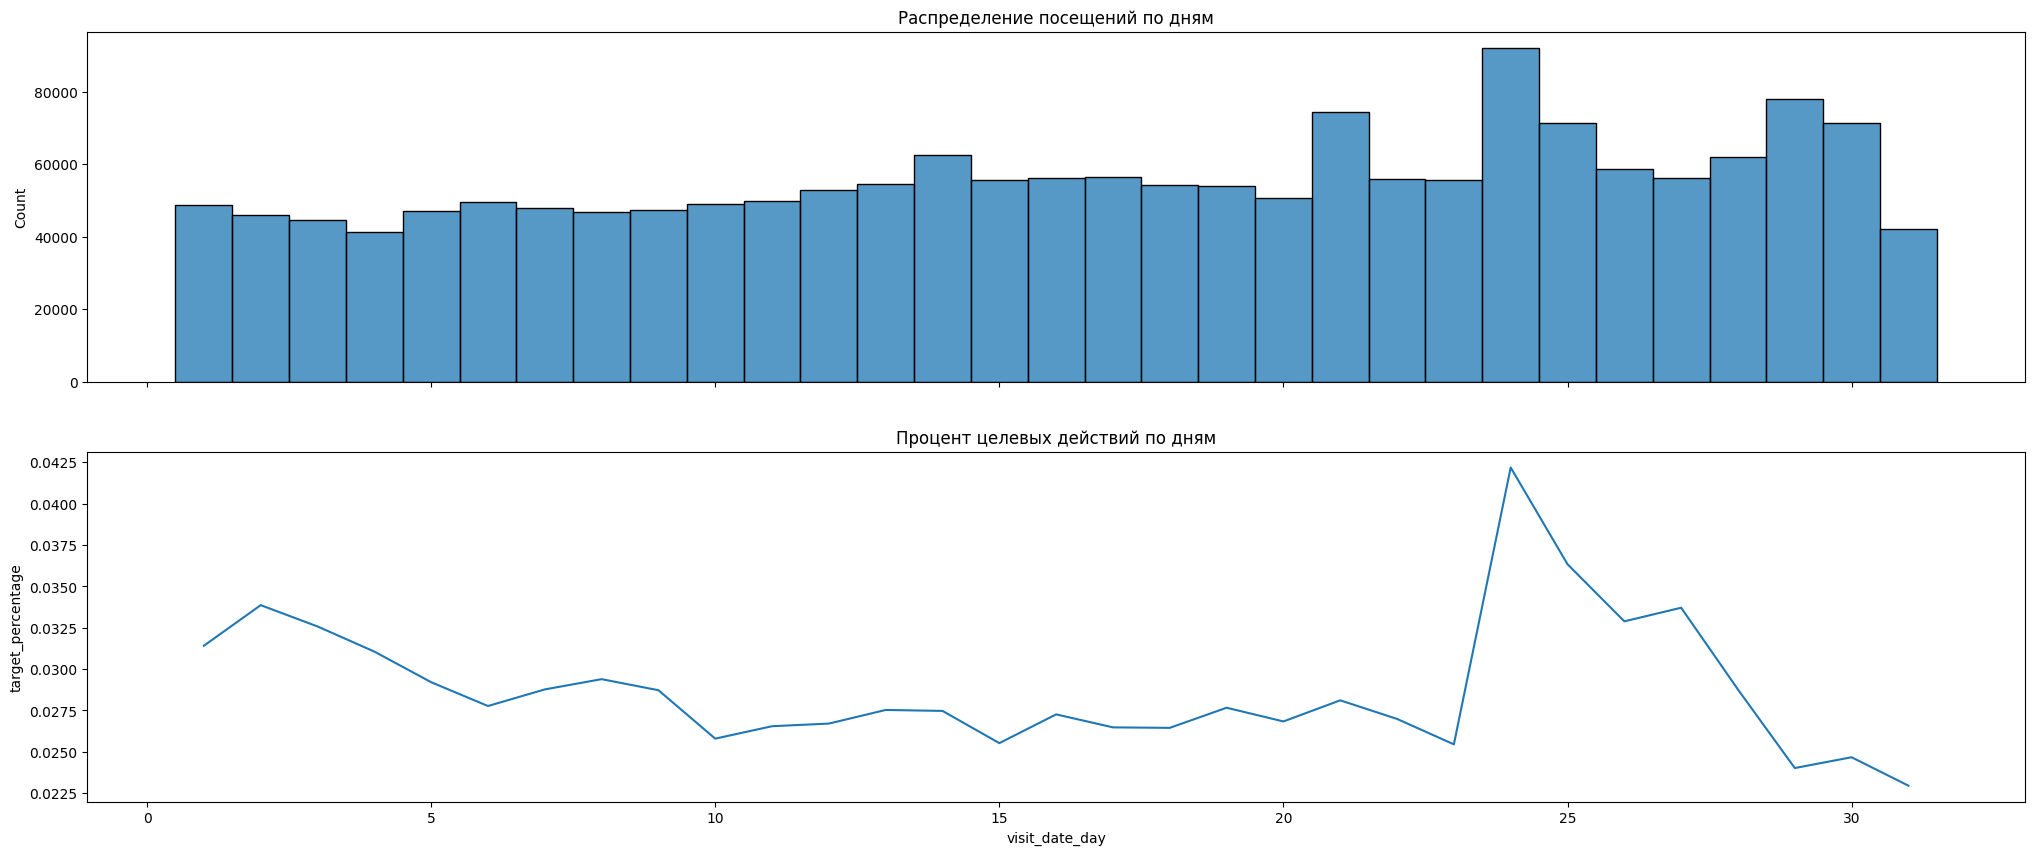

In [ ]:
_, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(25, 10))

ax1.set_title('Распределение посещений по дням')
sns.histplot(data=df_inner, x='visit_date_day', discrete=True, ax=ax1)

target_by_day = target_percentage(df_inner, 'visit_date_day',
                                  percent=False, only_target=True)
ax2.set_title('Процент целевых действий по дням')
sns.lineplot(data=target_by_day, ax=ax2);

Посмотрим какой процент ЦД выпадает на** праздничные дни в РФ**

In [ ]:
import holidays

russian_holidays = holidays.Russia()

# Проверяем, является ли дата праздником
df_inner['visit_date_holiday'] = df_inner['visit_date'].isin(russian_holidays)

In [ ]:
print('Распределение праздничных дней:')
target_percentage(df_inner, 'visit_date_holiday', index_name='Праздник')

Распределение праздничных дней:


,count,Целевое действие,Доля от общего числа
Праздник,,,
False,1732266,2.9%,100.0%


Из признака **visit_time** выведем новый - количество посещений по часам **visit_time_hour**

In [ ]:
df_inner['visit_time'] = pd.to_datetime(df_inner['visit_time'])
df_inner['visit_time_hour'] = df_inner['visit_time'].dt.hour

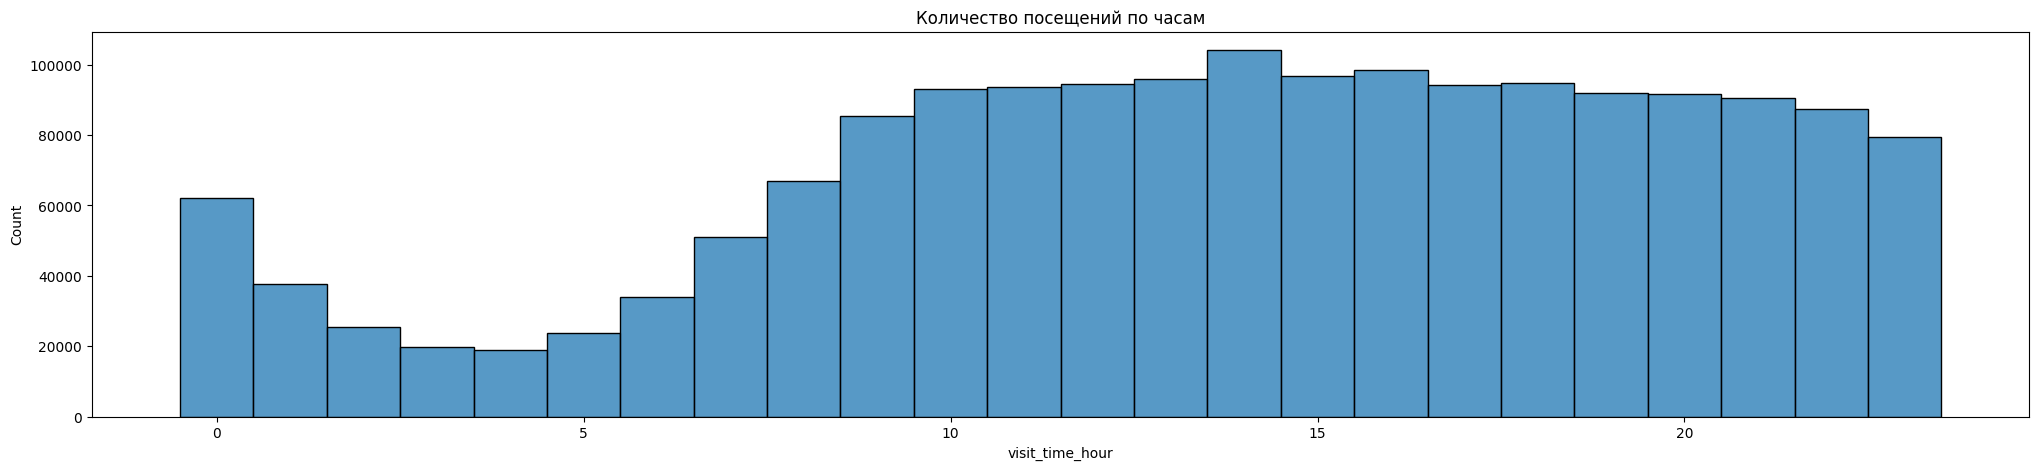

In [ ]:
plt.figure(figsize=(25, 5))
sns.histplot(data=df_inner, x='visit_time_hour', discrete=True)
plt.title('Количество посещений по часам');

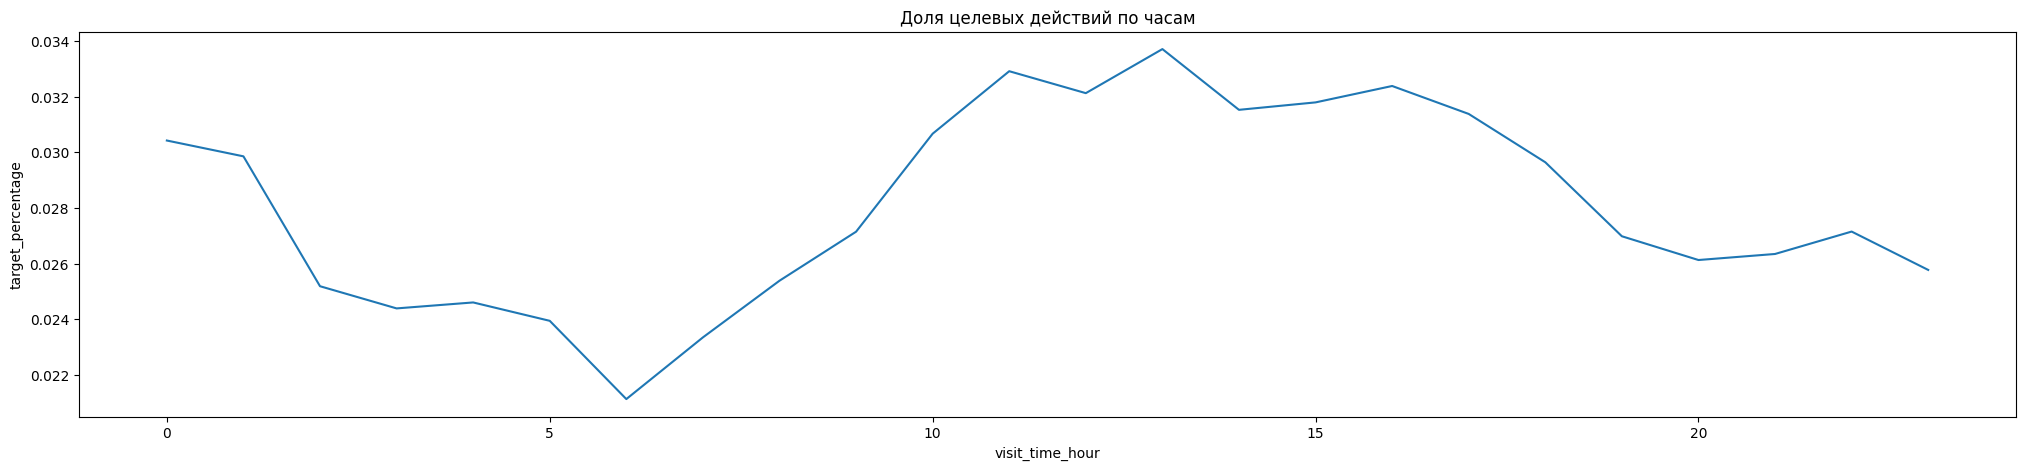

In [ ]:
plt.figure(figsize=(25, 5))
target_by_hour = target_percentage(df_inner, 'visit_time_hour',
                                   percent=False, only_target=True)
sns.lineplot(data=target_by_hour)
plt.title('Доля целевых действий по часам');

#Анализ посещений клиента

In [ ]:
df_inner['visit_number'].describe().apply(lambda x: f'{x:0.1f}')

,visit_number
count,1732266.0
mean,2.6
std,11.6
min,1.0
25%,1.0
50%,1.0
75%,1.0
max,564.0


In [ ]:
# приведём все выбросы к значению 4 (так как доля ЦД растет после 4 посещений)
df_inner['visit_number_no_outliers'] = df_inner['visit_number'].apply(lambda x: x if x < 4 else 4)

In [ ]:
print('Процент успешных сессий в зависимости от номера посещения: ')
target_percentage(df_inner, 'visit_number_no_outliers',
                  index_name='Номер посещения')

Процент успешных сессий в зависимости от номера посещения: 


,count,Целевое действие,Доля от общего числа
Номер посещения,,,
4,147156,4.95%,8.5%
3,71835,4.24%,4.15%
2,212176,3.59%,12.25%
1,1301099,2.49%,75.11%


#Анализ меток UTM

##utm_source

In [ ]:
print(f'Пропущенных значений в "utm_source": {df_inner.utm_source.isna().sum()}')

Пропущенных значений в "utm_source": 76


In [ ]:
n_unique = df_inner.utm_source.nunique()
print(f'Количество уникальных значений в `utm_source`: {n_unique}')

Количество уникальных значений в `utm_source`: 280


In [ ]:
df_inner.utm_source.value_counts(dropna=False).head(20)

,count
utm_source,
ZpYIoDJMcFzVoPFsHGJL,552555
fDLlAcSmythWSCVMvqvL,277060
kjsLglQLzykiRbcDiGcD,245178
MvfHsxITijuriZxsqZqt,175831
BHcvLfOaCWvWTykYqHVe,110963
bByPQxmDaMXgpHeypKSM,90356
QxAxdyPLuQMEcrdZWdWb,45267
aXQzDWsJuGXeBXexNHjc,29528
jaSOmLICuBzCFqHfBdRg,28288


In [ ]:
def replace_rare(series: pd.Series, threshold: float = 0.05) -> pd.Series:
    """
    Заменяет редкие категории в Series на 'rare_other' и пропуски на '(nan)'.

    Параметры:
    - series: pandas Series с категориальными данными
    - threshold: доля (от 0 до 1), ниже которой значение считается редким

    Возвращает:
    - Series с заменёнными редкими значениями и пропущенными значениями
    """
    series = series.copy()

    # Частота значений (включая NaN)
    value_counts = series.value_counts(dropna=False, normalize=True)

    # Выделим редкие значения
    rare_categories = value_counts[value_counts < threshold].index

    # Заменим редкие категории
    series = series.apply(lambda x: 'rare_other' if x in rare_categories else x)

    # Заменим NaN на строку
    return series.fillna('(nan)')


# Применим функцию и посчитаем статистику
print('Процент целевых действий для частых значений канала привлечения:')

df_inner['utm_source_frequent'] = replace_rare(df_inner['utm_source'])

utm_stats = target_percentage(
    df_inner,
    group_col='utm_source_frequent',
    index_name='Канал привлечения'
)

display(utm_stats)


Процент целевых действий для частых значений канала привлечения:


,count,Целевое действие,Доля от общего числа
Канал привлечения,,,
bByPQxmDaMXgpHeypKSM,90356,6.15%,5.22%
fDLlAcSmythWSCVMvqvL,277060,3.8%,15.99%
BHcvLfOaCWvWTykYqHVe,110963,3.5%,6.41%
ZpYIoDJMcFzVoPFsHGJL,552555,2.9%,31.9%
kjsLglQLzykiRbcDiGcD,245178,2.57%,14.15%
rare_other,280323,2.07%,16.18%
MvfHsxITijuriZxsqZqt,175831,1.28%,10.15%


Выделим признак, относящийся к социальным сетям **utm_source_smm**

In [ ]:
# Идентификаторы социальных сетей в качестве источника.
social_media_sources = ['QxAxdyPLuQMEcrdZWdWb', 'MvfHsxITijuriZxsqZqt',
                        'ISrKoXQCxqqYvAZICvjs', 'IZEXUFLARCUMynmHNBGo',
                        'PlbkrSYoHuZBWfYjYnfw', 'gVRrcxiDQubJiljoTbGm']

df_inner['utm_source_smm'] =  df_inner['utm_source'].isin(social_media_sources) # Заполним 'True', если зашел из социальных сетей
df_inner['utm_source_smm']

,utm_source_smm
session_id,
9055434745589932991.1637753792.1637753792,False
905544597018549464.1636867290.1636867290,True
9055446045651783499.1640648526.1640648526,False
9055447046360770272.1622255328.1622255328,False
9055447046360770272.1622255345.1622255345,False
...,...
9055415581448263752.1640159305.1640159305,False
9055421130527858185.1622007305.1622007305,False
9055422955903931195.1636979515.1636979515,False


In [ ]:
print('Процент целевых действий для пользователей из соцсетей и остальных:')
target_percentage(df_inner, 'utm_source_smm', index_name='Из соцсетей')

Процент целевых действий для пользователей из соцсетей и остальных:


,count,Целевое действие,Доля от общего числа
Из соцсетей,,,
False,1475986,3.14%,85.21%
True,256280,1.57%,14.79%


##utm_medium

In [ ]:
print(f'Количество пустых значений в `utm_medium`: {df_inner.utm_medium.isna().sum()}')

Количество пустых значений в `utm_medium`: 0


In [ ]:
df_inner.utm_medium.value_counts(dropna=False).head(30)

,count
utm_medium,
banner,525206
cpc,399395
(none),277060
cpm,229791
referral,136851
organic,55009
email,28287
push,27710
stories,10472


In [ ]:
print('Процент целевых действий для частых значений типа привлечения:')
df_inner['utm_medium_frequent'] = replace_rare(df_inner['utm_medium'])
target_percentage(df_inner, 'utm_medium_frequent', index_name='Тип привлечения')

Процент целевых действий для частых значений типа привлечения:


,count,Целевое действие,Доля от общего числа
Тип привлечения,,,
referral,136851,5.98%,7.9%
(none),277060,3.8%,15.99%
banner,525206,2.88%,30.32%
rare_other,163963,2.71%,9.47%
cpc,399395,2.39%,23.06%
cpm,229791,1.1%,13.27%


Выделим органический трафик

In [ ]:
# Источники органического трафика в sessions['utm_medium'].
organic_mediums = ['organic', 'referral', '(none)']
df_inner['utm_medium_is_organic'] = df_inner['utm_medium'].isin(organic_mediums)

In [ ]:
df_inner.target

,target
session_id,
9055434745589932991.1637753792.1637753792,0
905544597018549464.1636867290.1636867290,0
9055446045651783499.1640648526.1640648526,0
9055447046360770272.1622255328.1622255328,0
9055447046360770272.1622255345.1622255345,0
...,...
9055415581448263752.1640159305.1640159305,0
9055421130527858185.1622007305.1622007305,0
9055422955903931195.1636979515.1636979515,0


In [ ]:
df_inner.groupby('utm_medium_is_organic').nunique()

,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,...,target,visit_date_weekday,visit_date_day,visit_date_holiday,visit_time_hour,part_of_day,visit_number_no_outliers,utm_source_frequent,utm_source_smm,utm_medium_frequent
utm_medium_is_organic,,,,,,,,,,,,,,,,,,,,,
False,1020339,226,84478,510,78,52,396,214,1135,3,...,2,7,31,1,1,1,4,6,2,4
True,325791,226,58701,357,208,3,214,185,266,3,...,2,7,31,1,1,1,4,5,2,3


In [ ]:
print('Распределение органического трафика:')
target_percentage(df_inner, 'utm_medium_is_organic',
                  index_name='Органический трафик')

Распределение органического трафика:


,count,Целевое действие,Доля от общего числа
Органический трафик,,,
True,468920,4.44%,27.07%
False,1263346,2.34%,72.93%


##utm_campaign - рекламная кампания

In [ ]:
n_unique = df_inner['utm_campaign'].nunique()
print(f'Количество уникальных значений в `utm_campaign` = {n_unique}')

Количество уникальных значений в `utm_campaign` = 406


In [ ]:
print('Процент целевых действий для самых частых значений рекламной кампании:')
df_inner['utm_campaign_frequent'] = replace_rare(df_inner['utm_campaign'], 0.05)
target_percentage(df_inner, 'utm_campaign_frequent',
                  index_name='Рекламная кампания')

Процент целевых действий для самых частых значений рекламной кампании:


,count,Целевое действие,Доля от общего числа
Рекламная кампания,,,
LTuZkdKfxRGVceoWkVyg,422992,4.49%,24.42%
(nan),195287,3.67%,11.27%
gecBYcKZCPMcVYdSSzKP,133247,3.41%,7.69%
LEoPHuyFvzoNfnzGgfcd,321286,2.91%,18.55%
rare_other,424504,1.84%,24.51%
FTjNLDyTrXaWYgZymFkV,234950,1.04%,13.56%


##utm_adcontent

In [ ]:
print('Процент целевых действий для частых значений utm_adcontent:')
df_inner['utm_adcontent_frequent'] = replace_rare(df_inner['utm_adcontent'])
target_percentage(df_inner, 'utm_adcontent_frequent')

Процент целевых действий для частых значений utm_adcontent:


,count,Целевое действие,Доля от общего числа
utm_adcontent_frequent,,,
JNHcPlZPxEMWDnRiyoBf,935408,3.63%,54.0%
(nan),304137,2.88%,17.56%
vCIpmpaGBnIQhyYNkXqp,179438,2.18%,10.36%
xhoenQgDQsgfEPYNPwKO,104381,1.22%,6.03%
rare_other,208902,1.16%,12.06%


##utm_keyword - ключевое слово

In [ ]:
df_inner['utm_keyword'].value_counts(dropna=False).head(15)

,count
utm_keyword,
NaN,1020752
puhZPIYqKXeFPaUviSjo,465950
aXQzDWsJuGXeBXexNHjc,18154
ITfrGJNwVsHBGJMAKoct,12395
pHqgLcdBQPSLcrTpLkdr,12320
hAmNSZmQkKQKAjZEGlgb,10422
UKNBOHebRIIsQRsjNKay,10287
IGUCNvHlhfHpROGclCit,6950
RkpOyeEPgcMBSDuHLQcj,6648


In [ ]:
print('Процент целевых действий для частых значений utm_keyword:')
df_inner['utm_keyword_frequent'] = replace_rare(df_inner['utm_keyword'], 0.01)
target_percentage(df_inner, 'utm_keyword_frequent')

Процент целевых действий для частых значений utm_keyword:


,count,Целевое действие,Доля от общего числа
utm_keyword_frequent,,,
(nan),1020752,3.39%,58.93%
puhZPIYqKXeFPaUviSjo,465950,2.4%,26.9%
rare_other,227410,1.97%,13.13%
aXQzDWsJuGXeBXexNHjc,18154,0.4%,1.05%


#Анализ устройств клиента

##device_category - тип устройства

In [ ]:
n_unique = df_inner['device_category'].nunique()
print(f'Количество уникальных значений в `device_category` = {n_unique}')

Количество уникальных значений в `device_category` = 3


In [ ]:
print('Процент целевых действий по категориям устройств: ')
target_percentage(df_inner, 'device_category', index_name='Тип устройства')

Процент целевых действий по категориям устройств: 


,count,Целевое действие,Доля от общего числа
Тип устройства,,,
desktop,346891,3.32%,20.03%
mobile,1368679,2.8%,79.01%
tablet,16696,2.53%,0.96%


##device_os - ОС устройства

In [ ]:
n_unique = df_inner['device_os'].nunique()
print(f'Количество уникальных значений в `device_os` = {n_unique}')

Количество уникальных значений в `device_os` = 13


In [ ]:
print('Процент целевых действий для популярных ОС: ')
df_inner['device_os_frequent'] = replace_rare(df_inner['device_os'], 0.01)
target_percentage(df_inner, 'device_os_frequent', index_name='ОС')

Процент целевых действий для популярных ОС: 


,count,Целевое действие,Доля от общего числа
ОС,,,
(nan),1013964,3.4%,58.53%
Macintosh,23415,3.3%,1.35%
Android,425520,2.22%,24.56%
iOS,182597,2.15%,10.54%
Windows,81740,2.0%,4.72%
rare_other,5030,1.79%,0.29%


##device_brand - марка устройства

In [ ]:
print('Процент целевых действий для частых значений марки устройства:')
df_inner ['device_brand_frequent'] = replace_rare(df_inner['device_brand'])
target_percentage(df_inner, 'device_brand_frequent',
                  index_name='Марка устройства')

Процент целевых действий для частых значений марки устройства:


,count,Целевое действие,Доля от общего числа
Марка устройства,,,
(nan),347196,3.32%,20.04%
Samsung,311641,3.23%,17.99%
Apple,503533,2.87%,29.07%
Huawei,173828,2.6%,10.03%
rare_other,126817,2.49%,7.32%
Xiaomi,269251,2.45%,15.54%


#Анализ гео данных

##geo_country - страна

In [ ]:
print('Процент целевых действий для стран с наибольшим посещением сайта:')
df_inner['geo_country_frequent'] = replace_rare(df_inner['geo_country'], 0.002)
target_percentage(df_inner, 'geo_country_frequent', index_name='Страна')

Процент целевых действий для стран с наибольшим посещением сайта:


,count,Целевое действие,Доля от общего числа
Страна,,,
Russia,1682423,2.92%,97.12%
rare_other,33247,2.69%,1.92%
Ukraine,8455,2.35%,0.49%
United States,8141,0.79%,0.47%


##geo_city - город




43% сессий из Москвы, 5% из Московской области, там же и больший процент ЦД.

In [ ]:
print('Процент целевых действий для городов с наибольшим посещением сайта:')
df_inner['geo_city_frequent'] = replace_rare(df_inner['geo_city'], 0.01)
target_percentage(df_inner, 'geo_city_frequent', index_name='Город')

Процент целевых действий для городов с наибольшим посещением сайта:


,count,Целевое действие,Доля от общего числа
Город,,,
Kazan,27689,4.11%,1.6%
Krasnodar,30260,3.57%,1.75%
Ufa,20283,3.15%,1.17%
Moscow,750928,3.15%,43.35%
Samara,23433,3.1%,1.35%
rare_other,453522,2.74%,26.18%
Nizhny Novgorod,20782,2.69%,1.2%
Yekaterinburg,33555,2.64%,1.94%
Saint Petersburg,278402,2.55%,16.07%


#Строим корреляции признаков